In [ ]:
!pip install keras-tuner

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras_tuner import HyperModel, RandomSearch
import matplotlib.pyplot as plt
import os

In [ ]:
import tensorflow_datasets as tfds

# Load dataset
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'rock_paper_scissors',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    as_supervised=True,
    with_info=True
)

In [ ]:
IMG_SIZE = 128
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

ds_train = (ds_train
            .map(preprocess)
            .cache()
            .shuffle(1000)
            .batch(BATCH_SIZE)
            .map(lambda x, y: (data_augmentation(x, training=True), y))
            .prefetch(tf.data.AUTOTUNE))

ds_val = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
ds_train.element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [ ]:
def residual_block(x, filters, downsample=False):
    identity = x
    stride = 2 if downsample else 1

    x = layers.Conv2D(filters, 3, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if downsample:
        identity = layers.Conv2D(filters, 1, strides=2, padding='same')(identity)

    x = layers.Add()([x, identity])
    x = layers.ReLU()(x)
    return x

In [ ]:
def build_model(hp):

  inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
  x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
  x = layers.BatchNormalization()(x)

  # Residual block
  for i in range(hp.Int('num_blocks', 2, 5)):
    x = residual_block(x, hp.Int(f'filters_{i}', 32, 128, step=32), downsample=(i % 2 == 0))

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(hp.Float('dropout', 0.2, 0.6, step=0.1))(x)
  outputs = layers.Dense(3, activation='softmax')(x)

  model = tf.keras.Model(inputs, outputs)
  model.compile(
      optimizer=tf.keras.optimizers.Adam(
          hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
      ),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )
  return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='rps_resnet_tuner',
    project_name='rock_paper_scissors'
)

tuner.search(ds_train, epochs=25, validation_data=ds_val)
best_model = tuner.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 00m 01s]

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 16m 30s


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 70 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     36,992 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │    147,584 │ re_lu[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      4,224 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 64, 64,    │          0 │ add[0][0]         │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    147,584 │ re_lu_1[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ re_lu_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 800,131 (3.05 MB)

 Trainable params: 798,531 (3.05 MB)

 Non-trainable params: 1,600 (6.25 KB)

In [ ]:
best_hp = tuner.get_best_hyperparameters(1)[0]
print("\n✅ Best hyperparameters found:")
print(best_hp.values)


✅ Best hyperparameters found:
{'num_blocks': 3, 'filters_0': 128, 'downsample_0': False, 'filters_1': 128, 'downsample_1': True, 'dropout': 0.2, 'learning_rate': 0.00018198308643131893, 'filters_2': 128, 'downsample_2': False, 'filters_3': 32, 'downsample_3': True, 'filters_4': 64, 'downsample_4': False}


In [ ]:
history = best_model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=15
)

Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 179ms/step - accuracy: 0.9864 - loss: 0.0541 - val_accuracy: 0.3571 - val_loss: 3.8518
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.9879 - loss: 0.0441 - val_accuracy: 0.3492 - val_loss: 15.0364
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.9931 - loss: 0.0407 - val_accuracy: 0.3413 - val_loss: 4.3002
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.9925 - loss: 0.0342 - val_accuracy: 0.3492 - val_loss: 18.9335
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.9886 - loss: 0.0463 - val_accuracy: 0.6389 - val_loss: 6.2178
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - accuracy: 0.9961 - loss: 0.0374 - val_accuracy: 0.7976 - val_loss: 0.8929
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.9956 - loss: 0.0234 - val_accuracy: 0.3611 - val_loss: 9.6818
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.9954 - loss: 0.0189 - val_accur

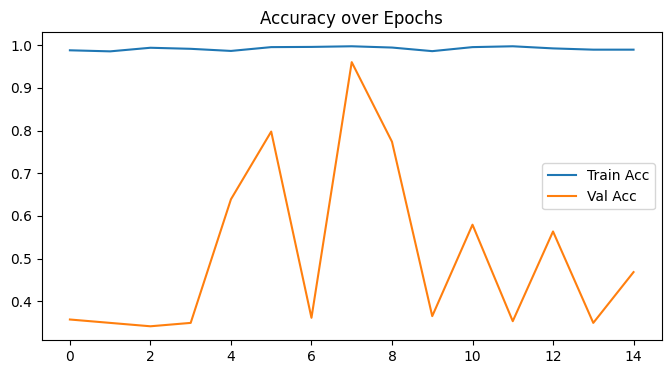

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

## Using RESNET

In [ ]:
import tensorflow_datasets as tfds

# Load dataset
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'rock_paper_scissors',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    as_supervised=True,
    with_info=True
)

In [ ]:
IMG_SIZE = 300
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

ds_train = (ds_train
            .map(preprocess)
            .cache()
            .shuffle(1000)
            .batch(BATCH_SIZE)
            .map(lambda x, y: (data_augmentation(x, training=True), y))
            .prefetch(tf.data.AUTOTUNE))

ds_val = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
base_model = tf.keras.applications.ResNet50V2(
    input_shape=(300, 300, 3),
    include_top=False,
    weights='imagenet'
)

In [ ]:
base_model.trainable = False

In [ ]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 10, 10, 2048)   │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │         6,147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,570,947 (89.92 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
# 🚀 Step 5: Train the Model
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=20
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 80s 944ms/step - accuracy: 0.7287 - loss: 0.7074 - val_accuracy: 0.9762 - val_loss: 0.2282
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 738ms/step - accuracy: 0.9838 - loss: 0.1791 - val_accuracy: 0.9802 - val_loss: 0.1315
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 727ms/step - accuracy: 0.9892 - loss: 0.1138 - val_accuracy: 0.9881 - val_loss: 0.0849
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 742ms/step - accuracy: 0.9899 - loss: 0.0751 - val_accuracy: 0.9881 - val_loss: 0.0640
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 741ms/step - accuracy: 0.9968 - loss: 0.0540 - val_accuracy: 0.9881 - val_loss: 0.0549
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 750ms/step - accuracy: 0.9969 - loss: 0.0455 - val_accuracy: 0.9960 - val_loss: 0.0464
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 703ms/step - accuracy: 0.9976 - loss: 0.0401 - val_accuracy: 1.0000 - val_loss: 0.0393
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 734ms/step - accuracy: 0.9961 - loss: 0.0345 - val_accu

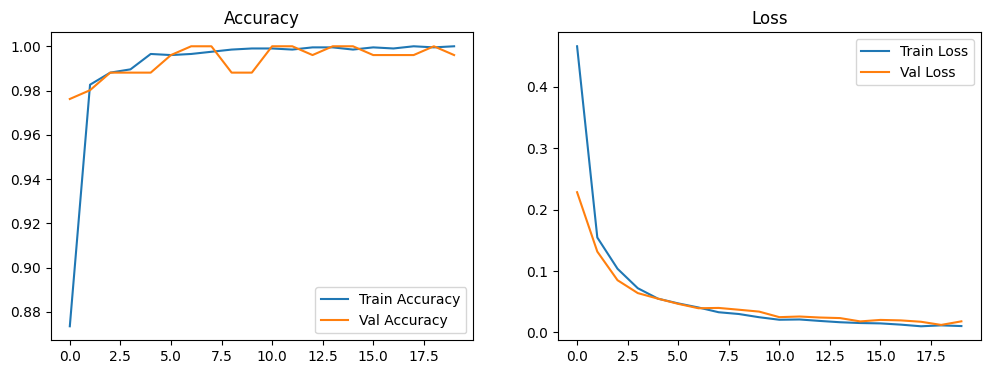

In [ ]:
# 📈 Step 6: Visualize Training Results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class_labels = ds_info.features['label'].names
print("Class labels:", class_labels)

Class labels: ['rock', 'paper', 'scissors']


In [ ]:
# Function to predict a batch of images
def predict_batch(model, dataset, num_samples=20):
    images, labels = [], []

    # Take enough images from the dataset
    for img, lbl in dataset.unbatch().take(num_samples):
        images.append(img.numpy())
        labels.append(lbl.numpy())

    images = np.array(images)
    labels = np.array(labels)

    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)

    return images, labels, pred_labels

In [ ]:
# Get predictions
images, labels, pred_labels = predict_batch(model, ds_test, num_samples=20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


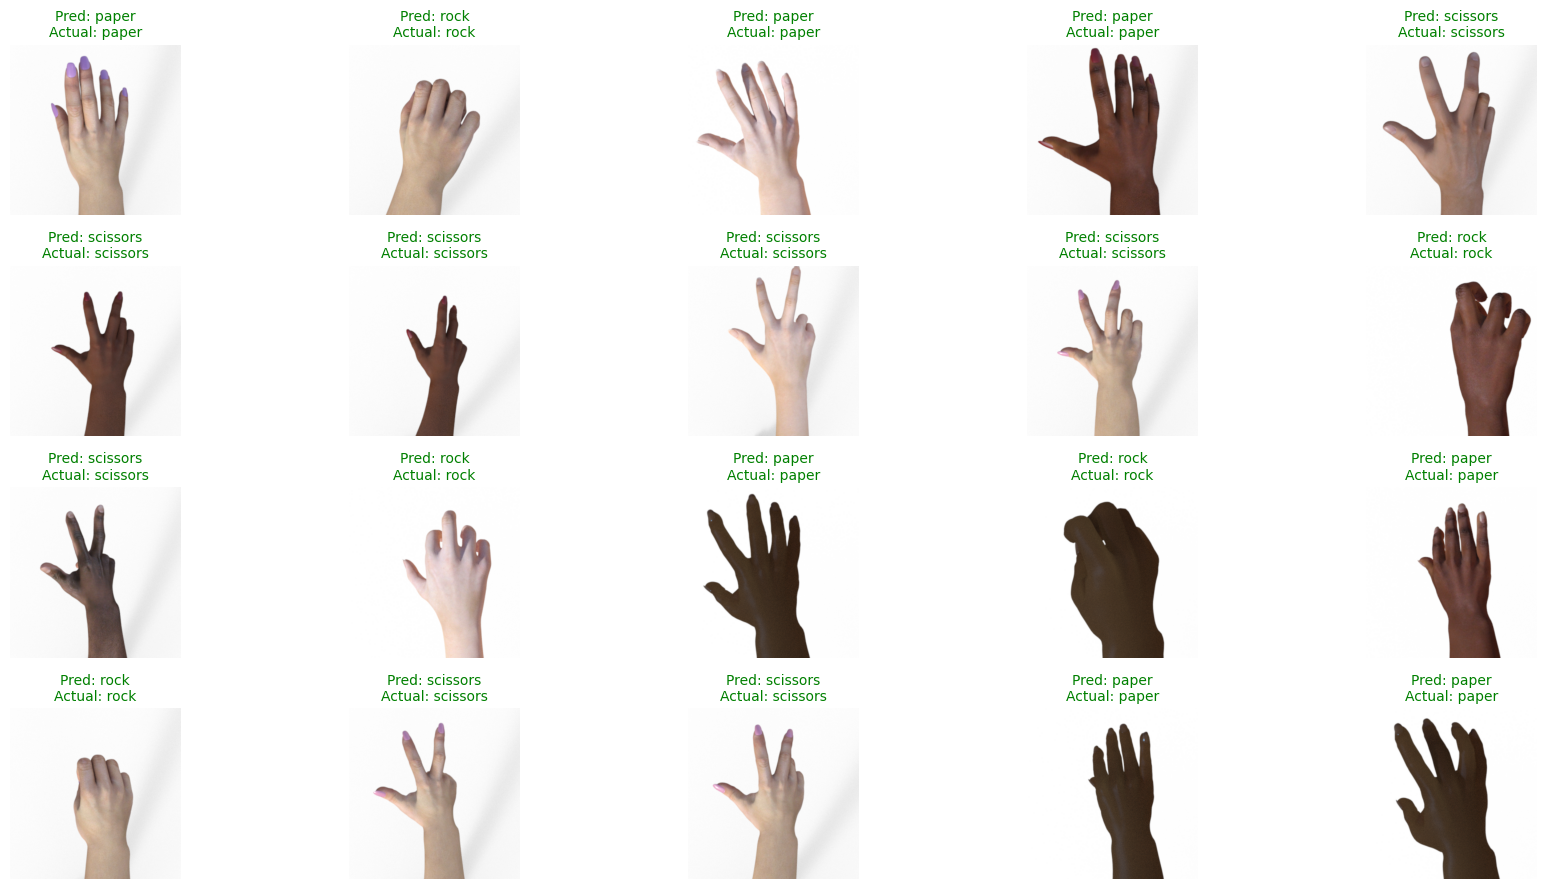

In [ ]:
# Plot results
plt.figure(figsize=(18, 9))
for i in range(len(images)):
    plt.subplot(4, 5, i + 1)
    plt.imshow(images[i])
    true_cls = class_labels[labels[i]]
    pred_cls = class_labels[pred_labels[i]]
    color = 'green' if true_cls == pred_cls else 'red'
    plt.title(f"Pred: {pred_cls}\nActual: {true_cls}", color=color, fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/DeepLearning_CampusX/rock_paper_scissors/rock_paper_scissors_model.keras")